<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2025a/blob/main/PINN_Couette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
# Install dependencies for Colab
!pip install pytorch-lightning clearml

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from clearml import Task
import matplotlib.pyplot as plt
import numpy as np


In [6]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV_
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I_

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


## Theoretical Introduction to PINNs for Parallel Plates Flow

We consider the steady flow of an incompressible Newtonian fluid between two infinite parallel plates separated by a gap $h$. Assuming the flow is unidirectional along the $x$-axis and the velocity varies only in the transverse coordinate $y$, the flow velocity $u(y)$ satisfies a simplified Navier-Stokes equation:

$$
\mu \frac{d^2 u}{dy^2} = \frac{dp}{dx}
$$

where $\mu$ is the dynamic viscosity,  $\frac{dp}{dx}$ is the constant pressure gradient driving the flow.

The fluid adheres to the no-slip boundary conditions on the plates:

$$
u\left(-\frac{h}{2}\right) = 0, \quad u\left(\frac{h}{2}\right) = 0
$$

The analytical solution to this boundary value problem is the classical parabolic velocity profile:

$$
u(y) = \frac{1}{2 \mu} \frac{dp}{dx} \left(\frac{h^2}{4} - y^2 \right)
$$

---

### Physics-Informed Neural Networks (PINNs)

PINNs approximate the solution $u(y)$ with a neural network that directly incorporates the governing differential equation and boundary conditions into the loss function. Instead of learning from data alone, PINNs minimize:

- a **PDE residual loss** to enforce the differential equation at sampled collocation points $y_i$,
- and a **boundary condition loss** to satisfy $u(\pm h/2)=0$.

The loss function combines these terms:

$$
\mathcal{L} =
\underbrace{
    \frac{1}{N_r} \sum_{i=1}^{N_r} \left| \mu \frac{d^2 \hat{u}}{dy^2}(y_i) - \frac{dp}{dx} \right|^2
}_{\text{PDE residual loss}}
+
\underbrace{
    \frac{1}{N_b} \sum_{j=1}^{N_b} \left| \hat{u}(y_j) - u_j \right|^2
}_{\text{Boundary loss}}
$$

where $\hat{u}$ is the neural network prediction, $N_r$ collocation points inside the domain, and $N_b$ boundary points.

---

This approach enables the neural network to learn solutions that satisfy physical laws inherently, requiring fewer data and guaranteeing physically plausible outputs. The example notebook implements this PINN framework in PyTorch Lightning, comparing the learned velocity profile with the exact analytical solution for validation.


# Model

In [7]:
# Initialize ClearML
task = Task.init(project_name='PINN_Project', task_name='Parallel Plates Flow PINN')

# PINN Model (a simple fully-connected NN)
class PINN(pl.LightningModule):
    def __init__(self, layers, mu, dpdx):
        super().__init__()
        self.mu = mu           # viscosity
        self.dpdx = dpdx       # pressure gradient (can be learnable)
        layer_list = []
        for i in range(len(layers)-1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)
        self.activation = nn.Tanh()

    def forward(self, y):
        out = y
        for i in range(len(self.layers)-1):
            out = self.activation(self.layers[i](out))
        out = self.layers[-1](out)
        return out

    def pinn_residual(self, y):
        """Calculate PDE residual: mu * u'' - dp/dx"""
        y = y.requires_grad_(True)
        u = self.forward(y)
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        residual = self.mu * u_yy - self.dpdx
        return residual

    def training_step(self, batch, batch_idx):
        y_bc, u_bc = batch['y_bc'], batch['u_bc']
        y_colloc = batch['y_colloc']

        # Boundary condition loss (no-slip)
        u_pred_bc = self.forward(y_bc)
        bc_loss = nn.functional.mse_loss(u_pred_bc, u_bc)
        self.log('bc_loss', bc_loss)

        # PDE residual loss
        residual = self.pinn_residual(y_colloc)
        pde_loss = torch.mean(residual**2)
        self.log('pde_loss', pde_loss)

        loss = bc_loss + pde_loss
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Data preparation (simple sampling for training)
def generate_data(n_bc=2, n_colloc=100):
    # Domain between y = -h/2 and h/2
    h = 1.0
    y_bc = torch.tensor([[-h/2], [h/2]], dtype=torch.float32)  # BC points
    u_bc = torch.zeros_like(y_bc)                              # u=0 at plates
    y_colloc = torch.linspace(-h/2, h/2, n_colloc).reshape(-1,1).float()  # collocation points (PDE residual)

    return {'y_bc': y_bc, 'u_bc': u_bc, 'y_colloc': y_colloc, 'h': h}

# Lightning DataModule for clean batch management
class PINNDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.data = generate_data()

    def train_dataloader(self):
        # Return a data loader with batch size 1 that yields the full dict
        return torch.utils.data.DataLoader([self.data], batch_size=1)

# Instantiate model and data module
mu = 1.0    # dynamic viscosity
dpdx = -1.0 # constant pressure gradient

model = PINN(layers=[1, 20, 20, 1], mu=mu, dpdx=dpdx)
data_module = PINNDataModule()

# Save a checkpoint every 10 epochs
checkpoint_callback = ModelCheckpoint(
    dirpath='my_checkpoints/',
    filename='pinn-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,            # only keep the top 3 checkpoints
    monitor='train_loss',    # or your preferred validation metric
    mode='min',
    every_n_epochs=50        # <<--- only every 10 epochs
)

trainer = pl.Trainer(
    max_epochs=600,
    accelerator='auto',
    callbacks=[checkpoint_callback],
    log_every_n_steps=10
)

# Train
trainer.fit(model, datamodule=data_module)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | layers     | ModuleList | 481    | train
1 | activation | Tanh       | 0      | train
--------------------------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the trai

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=600` reached.


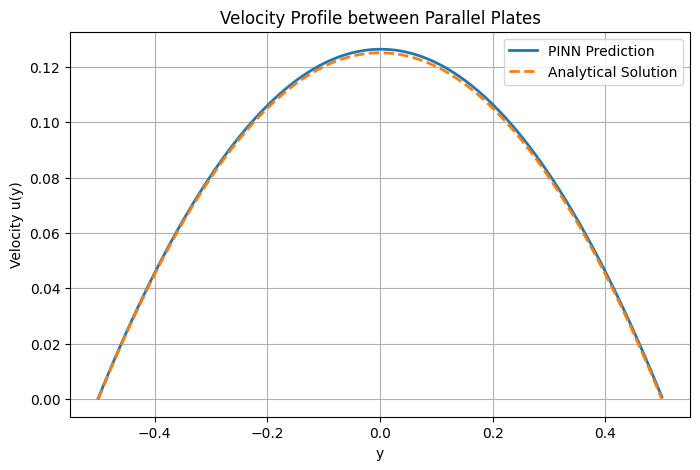

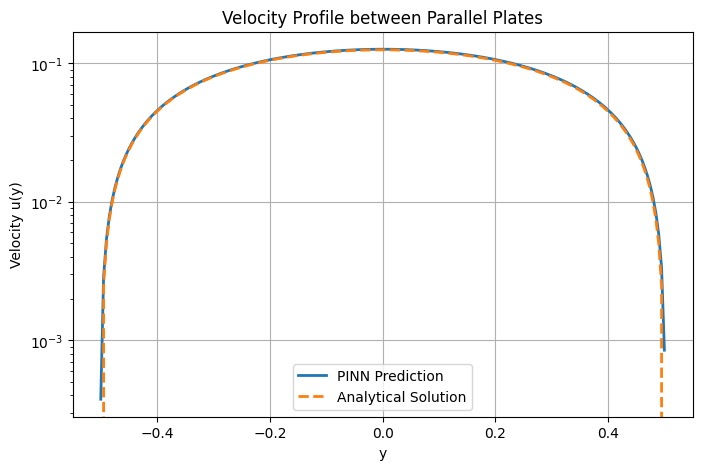

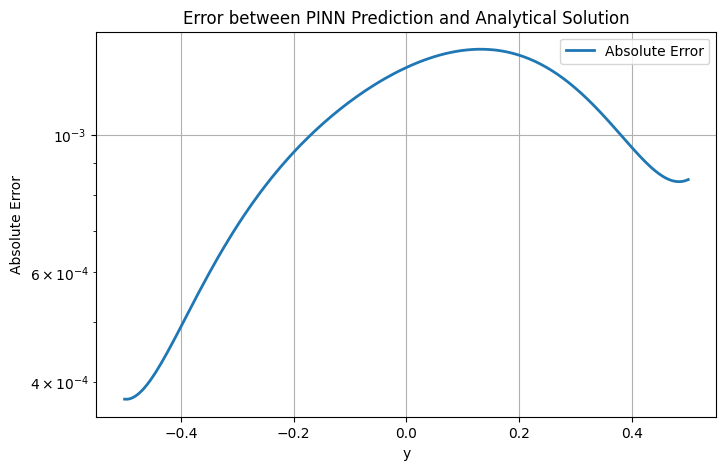

In [14]:


# Plot PINN vs Analytical

h = data_module.data['h']
y_vals = np.linspace(-h/2, h/2, 200).reshape(-1,1).astype(np.float32)
y_torch = torch.tensor(y_vals)

model.eval()
with torch.no_grad():
    u_pred = model(y_torch).cpu().numpy().flatten()

def analytical_solution(y, mu, dpdx, h):
    return (1/(2*mu)) * (-dpdx) * ((h**2)/4 - y**2)


u_analytical = analytical_solution(y_vals, mu, dpdx, h).flatten()

plt.figure(figsize=(8,5))
plt.plot(y_vals, u_pred, label='PINN Prediction', linewidth=2)
plt.plot(y_vals, u_analytical, '--', label='Analytical Solution', linewidth=2)
plt.xlabel('y')
plt.ylabel('Velocity u(y)')
plt.title('Velocity Profile between Parallel Plates')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(y_vals, u_pred, label='PINN Prediction', linewidth=2)
plt.plot(y_vals, u_analytical, '--', label='Analytical Solution', linewidth=2)
plt.xlabel('y')
plt.ylabel('Velocity u(y)')
plt.title('Velocity Profile between Parallel Plates')
plt.yscale('log')   # <-- set y-axis to logarithmic scale
plt.legend()
plt.grid(True)
plt.show()

error = np.abs(u_pred - u_analytical) + 1e-8  # add a small value to avoid log(0)
plt.figure(figsize=(8,5))
plt.plot(y_vals, error, label='Absolute Error', linewidth=2)
plt.xlabel('y')
plt.ylabel('Absolute Error')
plt.title('Error between PINN Prediction and Analytical Solution')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
task.close()